# Time Series Classification and Clustering

In a typical classification problem you are given a set of input features and a set of discrete output classes and you want to model the relationship between the two.  There is a myriad of classification algorithms that you could use for this problem - SVMs, Naive Bayes, k-NN, etc.  But what if the input features are not independent such as with time series data?  In this case SVMs and Naive Bayes would not be a good choice since they assume that the input features are independent.  The k-NN algorithm could still work however it relies on the notion of a similarity measure between input examples.  Now the question becomes _how do we measure the similarity between two time series_?

## How about Euclidean distance?

The Euclidean distance between two time series $Q$ and $C$ of length $n$ is defined as

$$d(Q,C) = \sqrt{\sum^n_{i=1}[Q(i)-C(i)]^2}$$

At first glance, it seems like simply calculating the Euclidean distance between two time series would give us a good idea of the similarity between them.  After all, the Euclidean distance between identical time series is zero and the Euclidean distance between very different time series is large.  However, before we settle on Euclidean distance as a similarity measure we should clearly state our desired criteria for determining the similarity between two time series 

With a good similarity measure, small changes in two time series should result in small changes in their similarity.  With respect to Euclidean distance this is true for changes in the y-axis, but it is not true for changes in the time axis (i.e. compression and stretching).  Consider the following example.

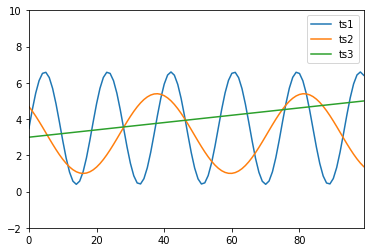

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from math import sqrt

x=np.linspace(0,50,100)
ts1=pd.Series(3.1*np.sin(x/1.5)+3.5)
ts2=pd.Series(2.2*np.sin(x/3.5+2.4)+3.2)
ts3=pd.Series(0.04*x+3.0)

ts1.plot()
ts2.plot()
ts3.plot()

plt.ylim(-2,10)
plt.legend(['ts1','ts2','ts3'])
plt.show()

In the above example, it is clear that $ts1$ and $ts2$ are most similar (they are both $sin$ functions under different transformations).  $ts3$ is clearly the most different. Let's compute the Euclidean distance $d(ts1,ts2)$ and $d(ts1,ts3)$ to see if the Euclidean distance measure agrees with what our intuition tells us.  Let's first create a function that computes the Euclidean distance between two time series.

In [2]:
def euclid_dist(t1,t2):
    return sqrt(sum((t1-t2)**2))

Let's now find the Euclidean distance between $ts1$ and $ts2$

In [3]:
print (euclid_dist(ts1,ts2))

26.95921603796934


and the Euclidean distance between $ts1$ and $ts3$

In [4]:
print (euclid_dist(ts1,ts3))

23.189249190311056


This is not good because according to the Euclidean distance measure, $ts1$ is more similar to $ts3$ than to $ts2$ which contradicts our intuition.  This is the problem with using the Euclidean distance measure.  It often produced pessimistic similarity measures when it encounters distortion in the time axis.  The way to deal with this is to use dynamic time warping.

## Dynamic Time Warping

Dynamic time warping finds the optimal non-linear alignment between two time series.  The Euclidean distances between alignments are then much less susceptable to pessimistic similarity measurements due to distortion in the time axis.  There is a price to pay for this, however, because dynamic time warping is quadratic in the length of the time series used.

Dynamic time warping works in the following way. Consider two time series $Q$ and $C$ of the same length $n$ where $$Q=q_1,q_2,...,q_n$$ and $$C=c_1,c_2,...,c_n$$ The first thing we do is construct an $n\times n$ matrix whose $i,j^{th}$ element is the Euclidean distance between $q_i$ and $c_j$.  We want to find a path through this matrix that minimizes the cumulative distance.  This path then determines the optimal alignment between the two time series.  It should be noted that it is possible for one point in a time series to be mapped to multiple points in the other time series.

Let's call the path $W$ where $$W=w_1,w_2,...,w_K$$ where each element of $W$ represents the distance between a point $i$ in $Q$ and a point $j$ in $C$ i.e. $w_k=(q_i-c_j)^2$

So we want to find the path with the minimum Euclidean distance $$W^*=argmin_W(\sqrt{\sum_{k=1}^Kw_k})$$ The optimal path is found via dynamic programming, specifically the following recursive function. $$\gamma(i,j)=d(q_i,c_j)+min ( \gamma(i-1,j-1),\gamma(i-1,j),\gamma(i,j-1))$$ 

In [5]:
def DTWDistance(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return sqrt(DTW[len(s1)-1, len(s2)-1])

In [32]:
def DTWDistanceLong(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return sqrt(DTW[len(s1)-1, len(s2)-1])

Now let's compute the Euclidean distance between $ts1$ and $ts2$ using dynamic time warping.

In [6]:
print (DTWDistance(ts1,ts2))

17.929718468641134


and now the dynamic time warping distance between $ts1$ and $ts3$

In [7]:
print (DTWDistance(ts1,ts3))

21.549494824404572


As you can see, our results have changed from when we only used the Euclidean distance measure.  Now, in agreement with our intuition, $ts2$ is shown to be more similar to $ts1$ than $ts3$ is.

### Speeding Up Dynamic Time Warping

Dynamic time warping has a complexity of $O(nm)$ where $n$ is the length of the first time series and $m$ is the length of the second time series.  If you are performing dynamic time warping multiple times on long time series data, this can be prohibitively expensive.  However, there are a couple of ways to speed things up.  The first is to enforce a locality constraint.  This works under the assumption that it is unlikely for $q_i$ and $c_j$ to be matched if $i$ and $j$ are too far apart.  The threshold is determined by a window size $w$.  This way, only mappings within this window are considered which speeds up the inner loop. The following is the modified code which includes the window size $w$.

In [8]:
def DTWDistance(s1, s2,w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return sqrt(DTW[len(s1)-1, len(s2)-1])

Let's test this faster version.

In [9]:
print (DTWDistance(ts1,ts2,10))

18.59655183841726


In [10]:
print (DTWDistance(ts1,ts3,10))

22.47248284679103


Another way to speed things up is to use the _LB Keogh_ lower bound of dynamic time warping.  It is defined as $$LBKeogh(Q,C)=\sum_{i=1}^n (c_i-U_i)^2I(c_i > U_i)+(c_i-L_i)^2I(c_i < L_i)$$
where $U_i$ and $L_i$ are upper and lower bounds for time series $Q$ which are defined as $U_i=max(q_{i-r}:q_{i+r})$ and $L_i=min(q_{i-r}:q_{i+r})$ for a reach $r$ and $I(\cdot)$ is the indicator function. It can be implemented with the following function.

In [11]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return sqrt(LB_sum)

Let's now test on $ts1$ and $ts2$

In [12]:
print (LB_Keogh(ts1,ts2,20))

6.253892351594148


and now $ts1$ and $ts3$.

In [13]:
print (LB_Keogh(ts1,ts3,20))

19.959547869419755


The _LB Keogh_ lower bound method is linear whereas dynamic time warping is quadratic in complexity which make it very advantageous for searching over large sets of time series. 

## Classification and Clustering

Now that we have a reliable method to determine the similarity between two time series, we can use the k-NN algorithm for classification.  Empirically, the best results have come when $k=1$.  The following is the 1-NN algorithm that uses dynamic time warping Euclidean distance.  In this algorithm, $train$ is the training set of time series examples where the class that the time series belongs to is appended to the end of the time series.  $test$ is the test set whose corresponding classes you are trying to predict.  In this algorithm, for every time series in the test set, a search must be performed through all points in the training set so that the most similar point is found.  Given that dynamic time warping is quadratic, this can be very computationally expensive.  We can speed up classification using the _LB Keogh_ lower bound.  Computing _LB Keogh_ is much less expensive than performing dynamic time warping.  And since $LB Keogh(Q,C) \leq DTW(Q,C)$ , we can eliminate time series that cannot possibly be more similar that the current most similar time series. In this way we are eliminating many unnecessary dynamic time warping computations.

In [14]:
from sklearn.metrics import classification_report

def knn(train,test,w):
    preds=[]
    for ind,i in enumerate(test):
        min_dist=float('inf')
        closest_seq=[]
        #print ind
        for j in train:
            if LB_Keogh(i[:-1],j[:-1],5)<min_dist:
                dist=DTWDistance(i[:-1],j[:-1],w)
                if dist<min_dist:
                    min_dist=dist
                    closest_seq=j
        preds.append(closest_seq[-1])
    return classification_report(test[:,-1],preds)

Now let's test it on some data. We will use a window size of 4.  Although the code is sped up with the use of the _LB Keogh_ bound and the dynamic time warping locality contraint, it may still take a few minutes to run.

In [15]:
train = np.genfromtxt('datasets/train.csv', delimiter='\t')
test = np.genfromtxt('datasets/test.csv', delimiter='\t')
print (knn(train,test,4))

             precision    recall  f1-score   support

        1.0       1.00      0.96      0.98        50
        2.0       0.96      1.00      0.98        50
        3.0       1.00      1.00      1.00        50
        4.0       0.98      1.00      0.99        50
        5.0       1.00      1.00      1.00        50
        6.0       1.00      0.98      0.99        50

avg / total       0.99      0.99      0.99       300



The same idea can also be applied to k-means clustering.  In this algorithm, the number of clusters is set _apriori_ and similar time series are clustered together.

In [21]:
import random

def k_means_clust(data,num_clust,num_iter,w=5):
#     centroids=random.sample(data,num_clust)
    centroids = data[np.random.choice(data.shape[0], num_clust, replace=False), :]
#     print (centroids.shape)
    counter=0
    for n in range(num_iter):
        counter+=1
#         print (counter)
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
    
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    
    return centroids
        

Let's test it on the entire data set (i.e. the training set and the test set stacked together).

In [18]:
train = np.genfromtxt('datasets/train.csv', delimiter='\t')
test = np.genfromtxt('datasets/test.csv', delimiter='\t')
data=np.vstack((train[:,:-1],test[:,:-1]))

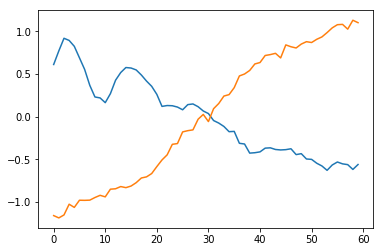

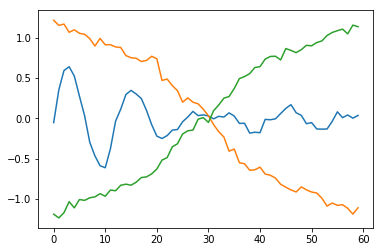

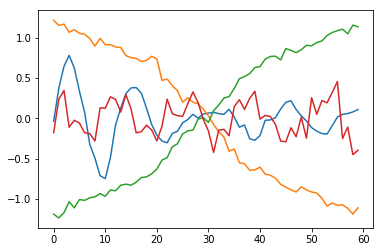

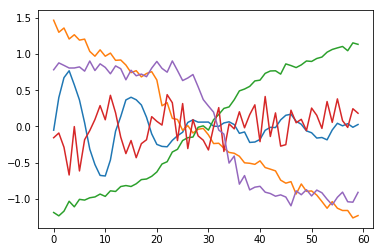

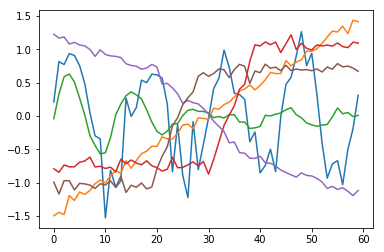

In [22]:
import matplotlib.pylab as plt
for num_clust in range(2,7):
    centroids=k_means_clust(data,num_clust,10,4)
    for i in centroids:
        plt.plot(i)
    plt.show()

In [29]:
import scipy
# scipy.stats.describe(data)
scipy.stats.describe(np.mean(data,axis=1))

DescribeResult(nobs=600, minmax=(-7.2166666531536805e-09, 7.8316666522286006e-09), mean=5.3850000557428472e-11, variance=5.3129581599614525e-18, skewness=0.08203125667468793, kurtosis=0.20302134143713157)

In [33]:
import random

def k_means_clust_modified(data,num_clust,num_iter):
#     centroids=random.sample(data,num_clust)
    centroids = data[np.random.choice(data.shape[0], num_clust, replace=False), :]
#     print (centroids.shape)
    counter=0
    for n in range(num_iter):
        counter+=1
#         print (counter)
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
#                 if LB_Keogh(i,j,5)<min_dist:
                cur_dist=DTWDistanceLong(i,j)
                if cur_dist<min_dist:
                    min_dist=cur_dist
                    closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
    
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    
    return centroids

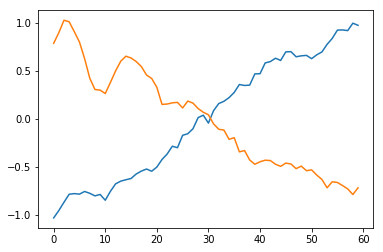

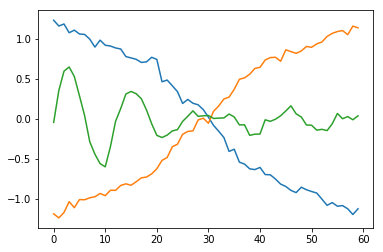

In [34]:
import matplotlib.pylab as plt
for num_clust in range(2,4):
    centroids=k_means_clust_modified(data,num_clust,10)
    for i in centroids:
        plt.plot(i)
    plt.show()

In [ ]:
# A[np.random.choice(A.shape[0], 2, replace=False), :]

In [46]:
cluster_arr = []
for i in data:
    min_dist = float('inf')
    for index in range(0,len(centroids)) : 
        center = centroids[index]
        temp_dist = DTWDistanceLong(i,center)
        if temp_dist < min_dist : 
            min_clus = index
            min_dist = temp_dist
    cluster_arr.append(min_clus)

In [47]:
from collections import Counter
Counter(cluster_arr)

Counter({0: 197, 1: 201, 2: 202})

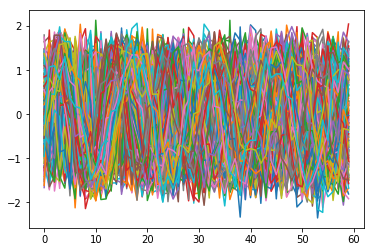

In [51]:
count = 0
for index in range(0,len(data)) :
    if cluster_arr[index] == 2 and count < 200:
        plt.plot(data[index])
        count += 1
plt.show()

In [85]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
# kmeans.euclidean_distances = DTWDistanceLong
kmeans.fit(data)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

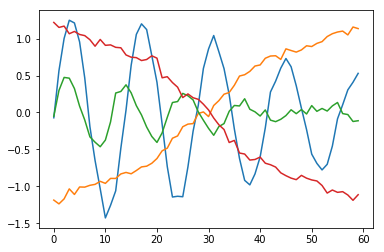

In [86]:
for i in kmeans.cluster_centers_:
    plt.plot(i)
plt.show()

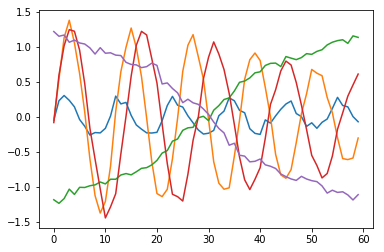

In [73]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.euclidean_distances = DTWDistanceLong
kmeans.fit(data)

for i in kmeans.cluster_centers_:
    plt.plot(i)
plt.show()


In [87]:
kmeans_predict = kmeans.predict(data)
Counter(kmeans_predict)

Counter({0: 44, 1: 200, 2: 156, 3: 200})

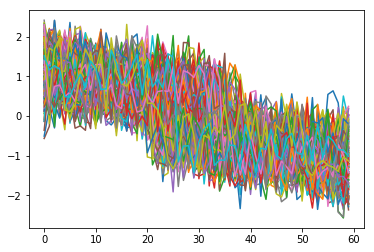

In [93]:
count = 0
for index in range(0,len(data)) :
    if kmeans_predict[index] == 3 and count < 300:
        plt.plot(data[index])
        count += 1
plt.show()

In [ ]:
#tackle scaling features before using kmeans or dbscan

from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.3, min_samples=10,metric=DTWDistanceLong)
db.fit(data)
db_pred = db.predict(data)
Counter(db_pred)


In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity
# def new_euclidean_distances(X, Y=None, Y_norm_squared=None, squared=False) 
#     return cosine_similarity(X,Y)

# # monkey patch (ensure cosine dist function is used)
# from sklearn.cluster import k_means_k_means_.euclidean_distances 
# k_means_.euclidean_distances = new_euclidean_distances 